# Capstone Project: Airbnb Prediciting Prices 
____

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Libraries for NPL and Regex
from nltk.tokenize import RegexpTokenizer
import re

In [4]:
# Reading datasets
listing = pd.read_csv('../data/listings.csv', low_memory=False)
neighbourhood_price = pd.read_csv('../data/Neighborhood_price.csv')

# 1. Data Cleanning 
___

## 1.1. Neighbourhood_price.csv

In [5]:
neighbourhood_price.head(3)

,Neighborhood,Median Price Per Sq Foot
0,West Village,7.68
1,Tribeca,7.64
2,NoMad,7.63


In [6]:
neighbourhood_price['Neighborhood'] = neighbourhood_price['Neighborhood'].str.lower()

In [7]:
neighbourhood_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Neighborhood              185 non-null    object 
 1   Median Price Per Sq Foot  185 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


In [8]:
neighbourhood_price.shape

(185, 2)

In [9]:
neighbourhoods = neighbourhood_price['Neighborhood'] 

## 1.2. Listing.csv

### 1.2.1 Checking for Null values

In [10]:
listing.shape

(39881, 75)

In [11]:
listing.head(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20220907064715,2022-09-07,city scrape,Clean & quiet apt home by the park,Renovated apt home in elevator building.<br />...,Close to Prospect Park and Historic Ditmas Park,https://a0.muscache.com/pictures/3949d073-a02e...,2787,...,5.0,4.75,4.88,NaN,f,9,1,6,2,0.11
1,2595,https://www.airbnb.com/rooms/2595,20220907064715,2022-09-07,city scrape,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,...,4.8,4.81,4.40,NaN,f,3,3,0,0,0.31


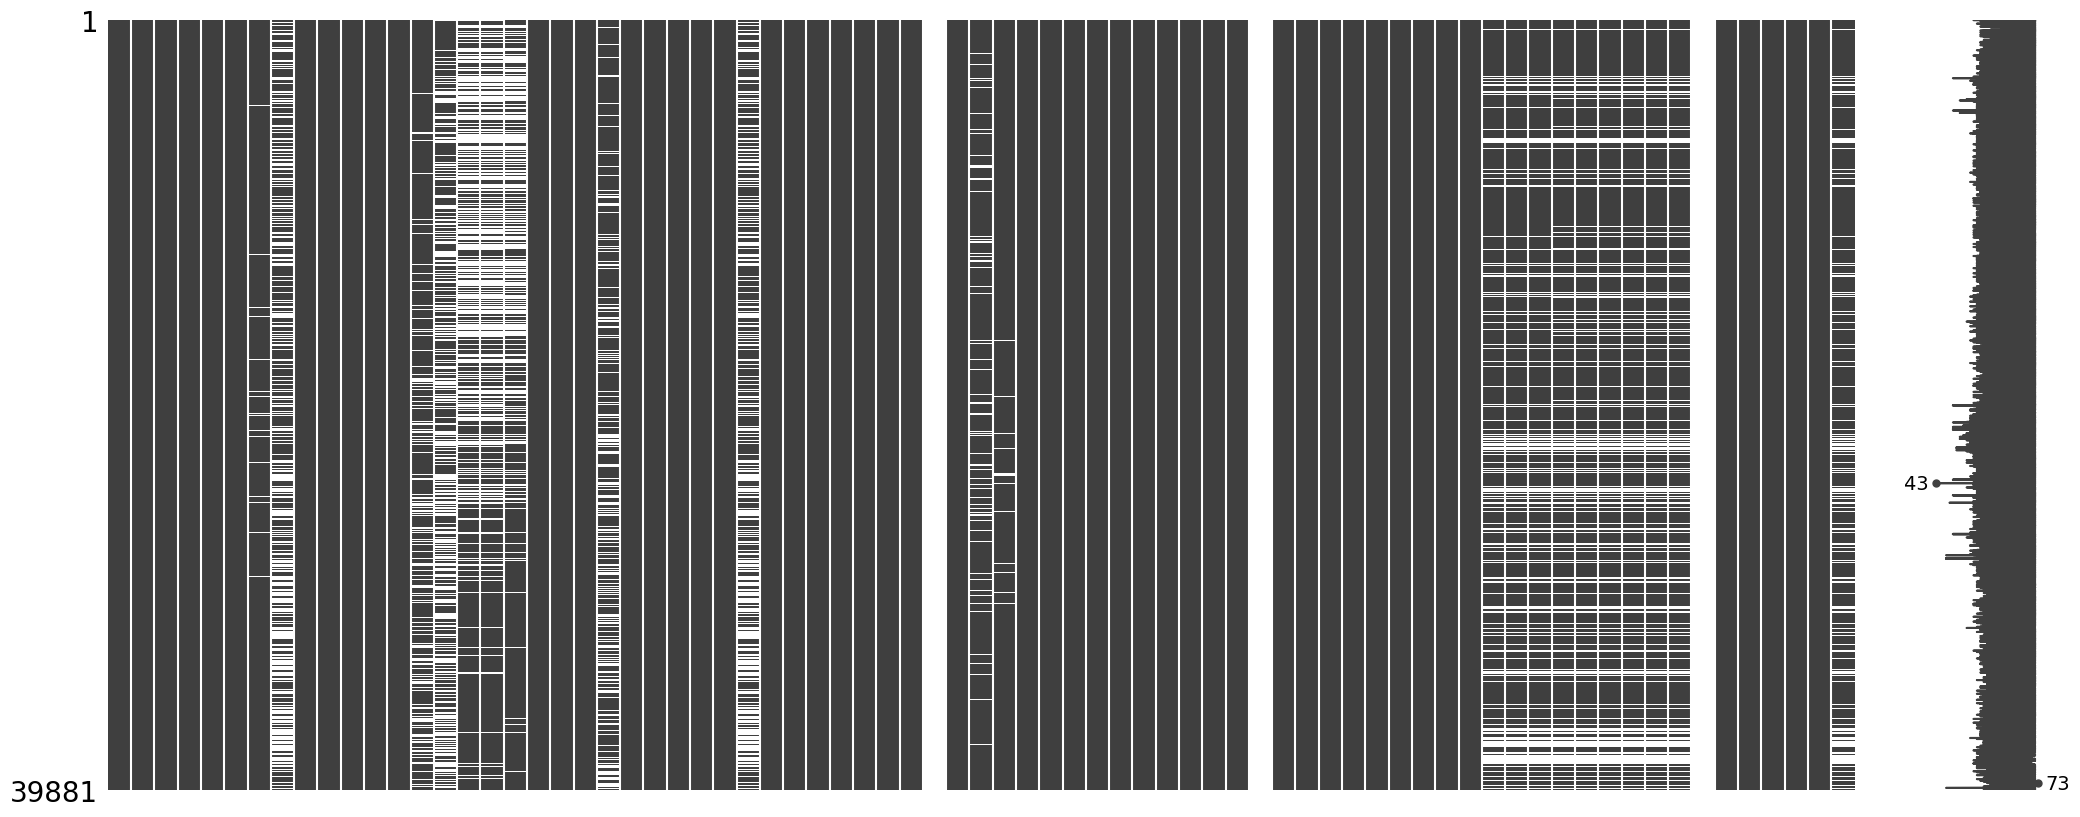

In [12]:
msno.matrix(listing);

### 1.2.3 Dropping Unecessary Columns for Modeling

Some columns like `'scrape_id', 'last_scraped'` and `'source'` has information that is not related to airbnb listing itself. Others columns are highly correlated to others like `'review_scores_value' and 'review_scores_rating'` so we are dropping it  and performing cleaning in the important ones.

In [13]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [14]:
col_del = ['listing_url', 'scrape_id', 'last_scraped', 'source', 
            'picture_url', 'host_url', 'host_since','host_location', 
            'host_thumbnail_url', 'host_picture_url','neighbourhood', 
            'property_type', 'host_neighbourhood', 'amenities', 
            'minimum_minimum_nights','maximum_minimum_nights', 
            'minimum_maximum_nights', 'maximum_maximum_nights', 
            'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 
            'calendar_updated', 'has_availability','availability_30', 
            'availability_60', 'availability_90', 'number_of_reviews_l30d', 
            'first_review','last_review', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin', 
            'review_scores_communication', 'review_scores_location',
            'review_scores_value', 'license', 'availability_365', 
            'host_listings_count','host_total_listings_count',
            'calendar_last_scraped', 'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes','host_response_time', 
            'host_response_rate', 'host_acceptance_rate',
            'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 
            'reviews_per_month', 'host_id', 'host_name', 
            'bathrooms','number_of_reviews_ltm']

In [15]:
listing.drop(columns=col_del, inplace=True)

In [16]:
listing.head(2)

,id,name,description,neighborhood_overview,host_about,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable
0,2539,Clean & quiet apt home by the park,Renovated apt home in elevator building.<br />...,Close to Prospect Park and Historic Ditmas Park,Educated professional living in Brooklyn. I l...,f,"['email', 'phone']",t,t,Kensington,...,2,1 shared bath,1.0,1.0,$299.00,30,730,9,4.89,f
1,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,A New Yorker since (Phone number hidden by Air...,f,"['email', 'phone', 'work_email']",t,t,Midtown,...,1,1 bath,NaN,1.0,$175.00,30,1125,49,4.68,f


In [17]:
listing.shape

(39881, 24)

I couldn't figure out a strategy to fill null values for bedrooms  and since it is not a big amount (less than 10%) of I'm junst dropping it.

In [18]:
listing['bedrooms'].isnull().sum()

3783

In [19]:
listing.dropna(subset='bedrooms', inplace=True)

### 1.2.4 Filling NaN Strategies

In [20]:
listing['description'] = listing['description'].fillna(" ")   
listing['neighborhood_overview'] = listing['neighborhood_overview'].fillna(" ") 
listing['host_about'] = listing['host_about'].fillna(" ") 
listing['bathrooms_text'] = listing['bathrooms_text'].fillna(" ") 
listing['name'] = listing['name'].fillna(" ") 

I'm making an assumption that if you have  a bedroom avaliable you do have at least one bed on it.

In [21]:
listing['beds'] = listing['beds'].fillna(1) 

In [22]:
listing['host_has_profile_pic'] = listing['host_has_profile_pic'].fillna('f') 
listing['host_identity_verified'] = listing['host_identity_verified'].fillna('f') 

### 1.2.5 Binarizing Columns 

In [23]:
#instant_bookable, host_identity_verified, host_has_profile_pic
listing['instant_bookable'] = listing['instant_bookable'].map({'t':1, 'f':0})
listing['host_identity_verified'] = listing['host_identity_verified'].map({'t':1, 'f':0}) 
listing['host_has_profile_pic'] = listing['host_has_profile_pic'].map({'t':1, 'f':0})
listing['host_is_superhost'] = listing['host_is_superhost'].map({'t':1, 'f':0})

### 1.2.6 Feature Engineering 

Removing chars from column price.

In [24]:
listing['price'] = listing['price'].str.replace('$','')
listing['price'] = listing['price'].str.replace(',','')

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_28383/2218781411.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listing['price'] = listing['price'].str.replace('$','')


Making feature engineering on the bathroom atribute.(i.e type and number of baths)

In [25]:
# cleaning
listing['bathrooms_text'] = listing['bathrooms_text'].str.replace('baths', '')
listing['bathrooms_text'] = listing['bathrooms_text'].str.replace('bath', '')

In [26]:
# Creating a tokenizer '([+-]?[0-9]*\.[0-9]*)'
tokenizer_nbr  = RegexpTokenizer(r'[0-9]\.?[0-9]?')
tokenizer_type = RegexpTokenizer(r'[A-Za-z]+')

# Creating a new column to keep these links
listing['bathrooms_type'] = listing['bathrooms_text'].map(lambda x:  tokenizer_type.tokenize(x))
listing['bathrooms_nbr'] = listing['bathrooms_text'].map(lambda x: tokenizer_nbr.tokenize(x))

In [27]:
listing['bathrooms_type'] = listing['bathrooms_type'].map(lambda x: str(x).replace('[]','private'))
listing['bathrooms_nbr'] = listing['bathrooms_nbr'].map(lambda x: str(x).replace('[]',"['0']"))

In [28]:
listing['bathrooms_type'] = listing['bathrooms_type'].map(lambda x: str(x).replace("['",''))
listing['bathrooms_type'] = listing['bathrooms_type'].map(lambda x: str(x).replace("']",''))
listing['bathrooms_nbr'] = listing['bathrooms_nbr'].map(lambda x: str(x).replace("['",''))
listing['bathrooms_nbr'] = listing['bathrooms_nbr'].map(lambda x: str(x).replace("']",''))

In [29]:
listing['bathrooms_type'].value_counts()

private            25002
shared             11040
Half                  28
Shared', 'half        18
Private', 'half       10
Name: bathrooms_type, dtype: int64

In [30]:
listing['bathrooms_type'] = listing['bathrooms_type'].map(lambda x: str(x).replace("Shared', 'half",'shared'))
listing['bathrooms_type'] = listing['bathrooms_type'].map(lambda x: str(x).replace("Private', 'half",'private'))
listing.drop(listing[listing['bathrooms_type']=='Half'].index, inplace=True)

In [31]:
listing['bathrooms_type'].value_counts()

private    25012
shared     11058
Name: bathrooms_type, dtype: int64

Creating column 'Price Per Square Feet'. We'll need to concatenate Neighborhood_price and Listing datasets.

In [32]:
listing['neighbourhood_cleansed'] = listing['neighbourhood_cleansed'].str.lower()
neighbourhoods_nyc = listing['neighbourhood_cleansed'].value_counts(ascending=True).index
neighbourhood_dif = (set((neighbourhoods_nyc)) - set(neighbourhoods))

In [33]:
neighbourhood_price.head()

,Neighborhood,Median Price Per Sq Foot
0,west village,7.68
1,tribeca,7.64
2,nomad,7.63
3,central park,7.53
4,noho,7.38


In [34]:
mapping = dict(neighbourhood_price[['Neighborhood', 'Median Price Per Sq Foot']].values)
listing['neigh_price_sqft'] = listing.neighbourhood_cleansed.map(mapping)

In [35]:
listing['neigh_price_sqft'].isnull().sum()

6127

In [36]:
listing.dropna(inplace=True)

eature engineering for description list count.

In [37]:
pattern = '<(.)>.?|<(.*) />'
listing['description'] = listing['description'].map(lambda x: re.sub(pattern,'', x))
listing['description_words'] = listing['description'].map(lambda x: re.findall('\w+', x))
listing['description_count'] = listing['description'].map(lambda x: len(x))

### 1.2.7 Converting Types

In [38]:
listing['bathrooms_nbr'] = listing['bathrooms_nbr'].astype(float)
listing['price'] = listing['price'].astype(float)
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23645 entries, 0 to 39877
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            23645 non-null  int64  
 1   name                          23645 non-null  object 
 2   description                   23645 non-null  object 
 3   neighborhood_overview         23645 non-null  object 
 4   host_about                    23645 non-null  object 
 5   host_is_superhost             23645 non-null  int64  
 6   host_verifications            23645 non-null  object 
 7   host_has_profile_pic          23645 non-null  int64  
 8   host_identity_verified        23645 non-null  int64  
 9   neighbourhood_cleansed        23645 non-null  object 
 10  neighbourhood_group_cleansed  23645 non-null  object 
 11  latitude                      23645 non-null  float64
 12  longitude                     23645 non-null  float64
 13  r

In [39]:
listing.shape

(23645, 29)

In [40]:
listing.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'host_about',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'bathrooms_type',
       'bathrooms_nbr', 'neigh_price_sqft', 'description_words',
       'description_count'],
      dtype='object')

In [41]:
listing.head(2)

,id,name,description,neighborhood_overview,host_about,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,bathrooms_type,bathrooms_nbr,neigh_price_sqft,description_words,description_count
0,2539,Clean & quiet apt home by the park,Renovated apt home in elevator building.If thi...,Close to Prospect Park and Historic Ditmas Park,Educated professional living in Brooklyn. I l...,0,"['email', 'phone']",1,1,kensington,...,30,730,9,4.89,0,shared,1.0,2.77,"[Renovated, apt, home, in, elevator, building,...",165
2,5121,BlissArtsSpace!,One room available for rent in a 2 bedroom apt...,,"I am an artist(painter, filmmaker) and curato...",1,"['email', 'phone']",1,1,bedford-stuyvesant,...,30,730,50,4.52,0,private,0.0,2.83,"[One, room, available, for, rent, in, a, 2, be...",447


In [42]:
model = listing[
       ['host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates',  'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'bathrooms_type',
       'bathrooms_nbr', 'neigh_price_sqft', 'description_count',
       'description_words']
       ]

In [43]:
model.to_csv('../data/listing_eda.csv', index=False)

In [44]:
model.shape

(23645, 23)